In [9]:
from pymongo import MongoClient
from pytz import timezone
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from bokeh.plotting import figure, output_notebook, show

%matplotlib inline



In [8]:
trainX = [[-0.5,0],[0,0],[-0.5,0],[0,0]]
trainY = [1,0,1,0]
sgd = SGDClassifier(loss="log")
sgd.fit(trainX,trainY)
sgd.coef_

array([[-15.94109017,   0.        ]])

In [76]:
def load_stopwords(file_location="SmartStoplist"):
    f = open(file_location)
    stopwords = [line.strip() for line in f]
    return stopwords + ["http","https", "don", "thi","http ", "co","dont","im"]

stopwords = load_stopwords()
stemmer = PorterStemmer()
stopSet = set(stopwords)

def preprocessor(text):
    stemmer = PorterStemmer()
    words = []
    global stopSet
    
    for word in text.lower().split():
        word = re.sub('[!@#$?\'\"]|&amp', '',word)
        stemmedWord = stemmer.stem_word(word)
        condition_Word = word not in stopSet  and "http" not in word
        condition_StemmedWord = stemmedWord not in stopSet
        
        if  condition_Word and  condition_StemmedWord:
            words.append(stemmedWord)
    return " ".join(words)

In [82]:
def emptyHourTable():
    return np.zeros(24,dtype=float)


def getEmotion(tweet):
    emotion = tweet["groups"][0]["name"]
    return emotion

def getLocalTime(time, zone):
    zoneTable = {"International Date Line West":"Pacific/Midway","Midway Island":"Pacific/Midway","American Samoa":"Pacific/Pago_Pago","Hawaii":"Pacific/Honolulu","Alaska":"America/Juneau","Pacific Time (US & Canada)":"America/Los_Angeles","Tijuana":"America/Tijuana","Mountain Time (US & Canada)":"America/Denver","Arizona":"America/Phoenix","Chihuahua":"America/Chihuahua","Mazatlan":"America/Mazatlan","Central Time (US & Canada)":"America/Chicago","Saskatchewan":"America/Regina","Guadalajara":"America/Mexico_City","Mexico City":"America/Mexico_City","Monterrey":"America/Monterrey","Central America":"America/Guatemala","Eastern Time (US & Canada)":"America/New_York","Indiana (East)":"America/Indiana/Indianapolis","Bogota":"America/Bogota","Lima":"America/Lima","Quito":"America/Lima","Atlantic Time (Canada)":"America/Halifax","Caracas":"America/Caracas","La Paz":"America/La_Paz","Santiago":"America/Santiago","Newfoundland":"America/St_Johns","Brasilia":"America/Sao_Paulo","Buenos Aires":"America/Argentina/Buenos_Aires","Montevideo":"America/Montevideo","Georgetown":"America/Guyana","Greenland":"America/Godthab","Mid-Atlantic":"Atlantic/South_Georgia","Azores":"Atlantic/Azores","Cape Verde Is.":"Atlantic/Cape_Verde","Dublin":"Europe/Dublin","Edinburgh":"Europe/London","Lisbon":"Europe/Lisbon","London":"Europe/London","Casablanca":"Africa/Casablanca","Monrovia":"Africa/Monrovia","UTC":"Etc/UTC","Belgrade":"Europe/Belgrade","Bratislava":"Europe/Bratislava","Budapest":"Europe/Budapest","Ljubljana":"Europe/Ljubljana","Prague":"Europe/Prague","Sarajevo":"Europe/Sarajevo","Skopje":"Europe/Skopje","Warsaw":"Europe/Warsaw","Zagreb":"Europe/Zagreb","Brussels":"Europe/Brussels","Copenhagen":"Europe/Copenhagen","Madrid":"Europe/Madrid","Paris":"Europe/Paris","Amsterdam":"Europe/Amsterdam","Berlin":"Europe/Berlin","Bern":"Europe/Berlin","Rome":"Europe/Rome","Stockholm":"Europe/Stockholm","Vienna":"Europe/Vienna","West Central Africa":"Africa/Algiers","Bucharest":"Europe/Bucharest","Cairo":"Africa/Cairo","Helsinki":"Europe/Helsinki","Kyiv":"Europe/Kiev","Riga":"Europe/Riga","Sofia":"Europe/Sofia","Tallinn":"Europe/Tallinn","Vilnius":"Europe/Vilnius","Athens":"Europe/Athens","Istanbul":"Europe/Istanbul","Minsk":"Europe/Minsk","Jerusalem":"Asia/Jerusalem","Harare":"Africa/Harare","Pretoria":"Africa/Johannesburg","Kaliningrad":"Europe/Kaliningrad","Moscow":"Europe/Moscow","St. Petersburg":"Europe/Moscow","Volgograd":"Europe/Volgograd","Samara":"Europe/Samara","Kuwait":"Asia/Kuwait","Riyadh":"Asia/Riyadh","Nairobi":"Africa/Nairobi","Baghdad":"Asia/Baghdad","Tehran":"Asia/Tehran","Abu Dhabi":"Asia/Muscat","Muscat":"Asia/Muscat","Baku":"Asia/Baku","Tbilisi":"Asia/Tbilisi","Yerevan":"Asia/Yerevan","Kabul":"Asia/Kabul","Ekaterinburg":"Asia/Yekaterinburg","Islamabad":"Asia/Karachi","Karachi":"Asia/Karachi","Tashkent":"Asia/Tashkent","Chennai":"Asia/Kolkata","Kolkata":"Asia/Kolkata","Mumbai":"Asia/Kolkata","New Delhi":"Asia/Kolkata","Kathmandu":"Asia/Kathmandu","Astana":"Asia/Dhaka","Dhaka":"Asia/Dhaka","Sri Jayawardenepura":"Asia/Colombo","Almaty":"Asia/Almaty","Novosibirsk":"Asia/Novosibirsk","Rangoon":"Asia/Rangoon","Bangkok":"Asia/Bangkok","Hanoi":"Asia/Bangkok","Jakarta":"Asia/Jakarta","Krasnoyarsk":"Asia/Krasnoyarsk","Beijing":"Asia/Shanghai","Chongqing":"Asia/Chongqing","Hong Kong":"Asia/Hong_Kong","Urumqi":"Asia/Urumqi","Kuala Lumpur":"Asia/Kuala_Lumpur","Singapore":"Asia/Singapore","Taipei":"Asia/Taipei","Perth":"Australia/Perth","Irkutsk":"Asia/Irkutsk","Ulaanbaatar":"Asia/Ulaanbaatar","Seoul":"Asia/Seoul","Osaka":"Asia/Tokyo","Sapporo":"Asia/Tokyo","Tokyo":"Asia/Tokyo","Yakutsk":"Asia/Yakutsk","Darwin":"Australia/Darwin","Adelaide":"Australia/Adelaide","Canberra":"Australia/Melbourne","Melbourne":"Australia/Melbourne","Sydney":"Australia/Sydney","Brisbane":"Australia/Brisbane","Hobart":"Australia/Hobart","Vladivostok":"Asia/Vladivostok","Guam":"Pacific/Guam","Port Moresby":"Pacific/Port_Moresby","Magadan":"Asia/Magadan","Srednekolymsk":"Asia/Srednekolymsk","Solomon Is.":"Pacific/Guadalcanal","New Caledonia":"Pacific/Noumea","Fiji":"Pacific/Fiji","Kamchatka":"Asia/Kamchatka","Marshall Is.":"Pacific/Majuro","Auckland":"Pacific/Auckland","Wellington":"Pacific/Auckland","Nuku'alofa":"Pacific/Tongatapu","Tokelau Is.":"Pacific/Fakaofo","Chatham Is.":"Pacific/Chatham","Samoa":"Pacific/Apia"}
    offset = timezone(zoneTable[zone]).utcoffset(datetime.now())
    return time + offset

def getTweetHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour



def getTweetSentimentHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour








def getUserEmotionFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = {}
            if emotion not in userFrequency[userID]:
                    userFrequency[userID][emotion] = emptyHourTable()
                    
            userFrequency[userID][emotion][hour] += 1
    
   
    if regularization:
        for userID in userFrequency:
            for emotion in userFrequency[userID]:
                total = sum(userFrequency[userID][emotion])
                if percentage:
                    total /= 100
                for i in range(24):
                    userFrequency[userID][emotion][i] /=  total
            
    return userFrequency

 


def getUserFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = emptyHourTable()
            userFrequency[userID][hour] += 1
    
    if regularization:
        for userID in userFrequency:
            total = sum(userFrequency[userID])
            if percentage:
                total /= 100
            for i in range(24):
                userFrequency[userID][i] /=  total
            
    return userFrequency


def frequencyPlot(userFrequency):
   
    X = []
    Y = []
    for hourTable in userFrequency.values():
        for i in range(24):
            if hourTable[i] < 0.3:
                X.append(i)
                Y.append(hourTable[i])
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=1)
    ax.plot(X, fit[0] * X + fit[1], color='red')
    ax.scatter(X, Y)

    fig.show()

    
    

 

def averagePlot(userFrequency, title):
    
    X = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    Y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for hourTable in userFrequency.values():
        for i in range(24): 
            Y[i] += hourTable[i]
    
    X = np.array(X)
    Y = np.array(Y)
    Y /= len(userFrequency)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=3)
    ax.plot(X, fit[0] * X**3+ + fit[1]*X**2+fit[2]*X+fit[3], color='red')
    ax.scatter(X, Y)
    ax.set_xlabel("Hour",  fontsize=14)
    ax.set_ylabel("Probablity to Post",  fontsize=14)
    fig.suptitle("{} {} people".format(len(userFrequency), title),  fontsize=18)
    
    fig.show()   

  

def personalPlot(userHour):  
        
    X = []
    Y = []

    for i in range(24):
        if userHour[i] > 0:
            X.append(i)
            Y.append(userHour[i])
            
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
   
    fit = np.polyfit(X, Y, deg=2)
    ax.plot(X, fit[0] * X**2+ + fit[1]*X+fit[2], color='red')
    ax.scatter(X, Y)
    plt.axis((0,24,0,0.2))
    fig.show()
  
    
    
    
    
def getUsersData(collectionName):
    
    
    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    usersData = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            text = tweet["text"]
            emotion = tweet["emotion"]["groups"][0]["name"]
            
            if userID not in usersData:
                usersData[userID] = {"emotions":{}, "texts": []}
            if emotion not in usersData[userID]["emotions"]:
                usersData[userID]["emotions"][emotion] = emptyHourTable()
            usersData[userID]["emotions"][emotion][hour] += 1
            usersData[userID]["texts"].append(text)
    
    for userID, data in usersData.items():
        total = len(data["texts"])
        for emotion in data["emotions"]:
            usersData[userID]["emotions"][emotion] /= total
    
            
    return usersData

In [78]:
regularUserFrequency = getUserEmotionFrequency("regularUser_en_fixed_emotion")
BPDUserFrequency = getUserEmotionFrequency("BPD_fixed_emotion")

In [345]:

 





def getTFIDF(usersDataList):
    textsList = []
    for usersData in usersDataList:
        texts = ""
        for data in usersData.values():
            for text in data["texts"]:
                texts += preprocessor(text) + "\n"
        textsList.append(texts)
 
    tfidf = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    tfidf.fit(textsList)
    return tfidf




 
        

    
def getEmotionFeature(usersDataList):
    
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    featuresList = []
    
    for usersData in usersDataList:
        features = []
        for data in usersData.values():
            feature = np.array([])
            for emotion in emotions:
                feature = np.concatenate((feature, (data["emotions"].get(emotion, emptyHourTable()))))
            features.append(feature)
        featuresList.append(np.array(features))
        
    return featuresList



def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
       model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    
    getText = lambda data : "\n".join(data["texts"])
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData.values():
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

def featureCombination(emotion_features, text_features):
    featuresList = []
    for i in range(len(emotion_features)):
        featuresList.append(hstack((emotion_features[i], text_features[i])))
    return featuresList
    

    
def featureExtraction(usersDataList, emotion_extraction=True, text_extraction=True, text_model="tfidf"):
    
    featuresList = []
 
    
    if emotion_extraction:
        emotion_features = getEmotionFeature(usersDataList)
        
        if not text_extraction:
            featuresList = emotion_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if emotion_extraction:
            featuresList = featureCombination(emotion_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    
    return list(zip(featuresList, Ylist)), model 
    
    
  

In [308]:
def trainTestGenerator(featuresList, randomState, verbose=Ture):
    x, y = featuresList[0]
    X_TRAIN,X_TEST, Y_TRAIN,Y_TEST = train_test_split(x,y, random_state=randomState)
    
    normal_train = X_TRAIN.shape[0]
    normal_test = X_TEST.shape[0]
    
    for x, y in featuresList[1:]:
        x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=randomState)
        
        X_TRAIN = vstack([X_TRAIN, x_train])    
        X_TEST = vstack([X_TEST, x_test]) 
        Y_TRAIN = np.concatenate((Y_TRAIN, y_train))   
        Y_TEST = np.concatenate((Y_TEST, y_test))
        
        BPD_train = x_train.shape[0]
        BPD_test = x_test.shape[0]
        
    if verbose:
            print("")
    
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [311]:
for i in range(10):
    X_train, X_test, Y_train, Y_test = trainTestGenerator(a, randomState = i)
    sgd = SGDClassifier(loss="log", shuffle=True)
    sgd.fit(X_train, Y_train)
    print(sgd.score(X_test, Y_test))

0.965517241379
0.954022988506
0.977011494253
0.954022988506
0.965517241379
0.965517241379
0.965517241379
0.988505747126
0.954022988506
0.954022988506


In [389]:
def plot_ROC(classifier, X_train, X_test, Y_train, Y_test ):
    classifier.fit(X_train, Y_train)
    scores = classifier.predict_proba(X_test)
    

    fpr, tpr, _ = roc_curve(Y_test, scores[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    try:
        print("Dimentions of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Dimentions of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier


In [378]:
def showImportantFeatures(features_importance, text_model, n_features = 10):
    print("The top {} most important features:\n".format(n_features))
    vector2word = text_model.get_feature_names()
    for vector in features_importance[:n_features]:
        if vector > len(features_importance):
            print("{}, A non textual feature".format(vector))
        else:
            word = vector2word[vector]


Dimentions of features: 3325862


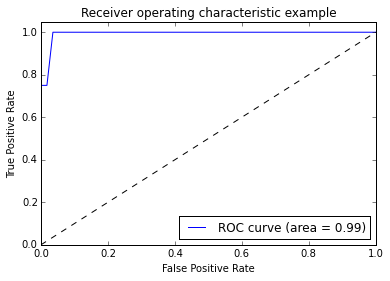

The top 50 most important features:

liv oh
dbuxqlbskw
recognition sumonefamous
carldunnjr missed
trillion service
bpdchat bpdqueen
healthcaregov
dial contains
dialed tweed
looking mighty
like emblem3
bad whoops
bphillips823
bpd read
amp dancers
bored baesleep
bpd_barney
cops deansgate
self publishing
happens shoe
particular day
xoxo_jazzmyne lol
ones pmiyinla
help crash
years champo
fingerscrossed today
champ fearless
sminy53x5g
amp sony
yes regan
xp8d52bchu
suit broken
times dynamomagician
learning toronto
week clickonthis
just eager
19th klaz393
emergencybeta rocks
bpdchat isn
suit business
innesengland speaking
bored avi
sweetraritea getting
need chinese
count fucked
work cherryberry
usahockey stays
neha_x check
female rocker
don tmesswithtexas


In [396]:
#BPDUsersData = getUsersData("BPD_fixed_emotion")
#regularUsersData = getUsersData("regularUser_en_fixed_emotion")
#featuresList, text_model = featureExtraction([regularUsersData, BPDUsersData])
#X_train, X_test, Y_train, Y_test = trainTestGenerator(featuresList, randomState =23)
classifer = plot_ROC(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=256), X_train, X_test, Y_train, Y_test)
#classifer = plot_ROC(SGDClassifier(loss="log",shuffle=True), X_train, X_test, Y_train, Y_test)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))[::-1]
showImportantFeatures(featureScores, text_model, n_features=50)